#Import Libraries


In [1]:
import tensorflow as tf
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


#Data


In [2]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Mini-project/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Mini-project/val'

In [3]:
os.listdir(train_path)

['fresh cotton leaf',
 'diseased cotton plant',
 'diseased cotton leaf',
 'fresh cotton plant']

In [4]:
os.listdir(valid_path)

['fresh cotton plant',
 'diseased cotton plant',
 'diseased cotton leaf',
 'fresh cotton leaf']

In [5]:
IMAGE_SIZE = [224, 224]

# Using ResNet152v2 architecture (Transfer Learning)

In [6]:
import tensorflow
densenet = DenseNet201(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

74842112/74836368 [==============================] - 1s 0us/step


In [7]:
for layer in densenet.layers:
    layer.trainable = False

##Obtain number of files

In [8]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print(f'number of image files = {len(image_files)} and number of validation files = {len(valid_image_files)}')

number of image files = 1951 and number of validation files = 324


In [9]:
folders = glob('/content/drive/MyDrive/Colab Notebooks/Mini-project/train/*')
K = len(folders)
K

4

#CNN model

In [10]:
x = Flatten()(densenet.output)

x = Dense(K, activation='softmax')(x)

In [11]:
model = Model(inputs=densenet.input, outputs=x)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Image augmentation

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
'-------------------------------------------------------------------------------'
batch_size = 16
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical'
                                                )
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical'
                                            )

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [14]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##Fit Generator

In [15]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
122/122 [==============================] - 830s 6s/step - loss: 1.5107 - accuracy: 0.8098 - val_loss: 0.3840 - val_accuracy: 0.9352
Epoch 2/20
122/122 [==============================] - 36s 294ms/step - loss: 0.6302 - accuracy: 0.9098 - val_loss: 0.2972 - val_accuracy: 0.9444
Epoch 3/20
122/122 [==============================] - 36s 292ms/step - loss: 0.6408 - accuracy: 0.9236 - val_loss: 0.4703 - val_accuracy: 0.9414
Epoch 4/20
122/122 [==============================] - 36s 292ms/step - loss: 0.5555 - accuracy: 0.9431 - val_loss: 0.2686 - val_accuracy: 0.9753
Epoch 5/20
122/122 [==============================] - 35s 290ms/step - loss: 0.6246 - accuracy: 0.9467 - val_loss: 0.4923 - val_accuracy: 0.9352
Epoch 6/20
122/122 [==============================] - 36s 291ms/step - loss: 0.8733 - accuracy: 0.9303 - val_loss: 0.8068 - val_accuracy: 0.9475
Epoch 7/20
122/122 [==============================] - 36s 291ms/step - loss: 0.5482 - accuracy: 0.9498 - val_loss: 0.1438 - val_accu

#Plot results

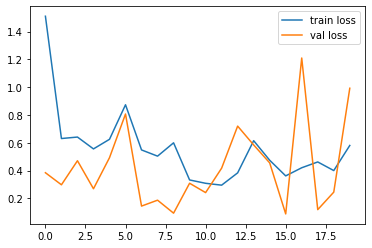

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

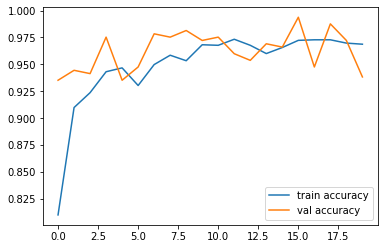

In [17]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

#Save Model

In [18]:
from tensorflow.keras.models import load_model

model.save('model_densenet201.h5')

#Predictions

In [35]:
pred = model.predict(test_set)

In [36]:
pred = np.argmax(pred, axis=1)
pred

array([3, 3, 1, 2, 1, 0, 3, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 2, 3, 2, 1,
       3, 0, 3, 3, 2, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 2, 2, 3, 1, 3, 0, 0,
       2, 0, 0, 3, 1, 0, 1, 3, 1, 1, 1, 0, 3, 1, 0, 2, 3, 3, 2, 1, 1, 0,
       3, 0, 1, 1, 1, 2, 2, 3, 0, 2, 1, 3, 1, 2, 1, 3, 0, 3, 3, 1, 2, 1,
       0, 1, 3, 1, 3, 1, 2, 0, 0, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 2, 3, 1,
       3, 2, 1, 1, 0, 3, 0, 0, 2, 1, 1, 3, 1, 0, 0, 3, 2, 0, 0, 1, 1, 3,
       0, 1, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 1, 3, 0, 1, 1, 3,
       2, 3, 1, 3, 2, 3, 0, 1, 1, 3, 1, 1, 3, 3, 0, 3, 2, 2, 2, 2, 0, 2,
       1, 1, 3, 0, 3, 0, 1, 3, 1, 1, 1, 0, 0, 3, 3, 2, 3, 1, 0, 2, 3, 2,
       2, 2, 3, 0, 0, 0, 0, 1, 3, 0, 3, 0, 2, 0, 2, 1, 3, 2, 2, 0, 1, 1,
       3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 2, 1, 0, 3, 1, 0, 0, 3, 1, 3, 2,
       0, 1, 0, 2, 0, 1, 3, 0, 2, 1, 2, 0, 1, 1, 3, 2, 1, 1, 3, 2, 0, 2,
       0, 3, 1, 3, 3, 3, 2, 3, 1, 2, 0, 3, 0, 3, 3, 3, 0, 2, 2, 3, 3, 1,
       3, 1, 1, 2, 1, 1, 3, 3, 1, 1, 0, 1, 1, 2, 2,